<a href="https://colab.research.google.com/github/Pankaj-2003/Numerai_Models/blob/main/feature_neutralization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One thing that makes predicting the stock market so hard is the "non-stationary" relationship between features and returns. Features can have strong predictive power some eras but not others - or may completely reverse over time.

This uncertainty is what we call "feature risk". In order to create models that have consistent performance, it is helpful to reduce this feature risk via "feature neutralization"

In [ ]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1

# Inline plots
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 29.0 MB/s eta 0:00:00


In [ ]:
import json
import pandas as pd
from numerapi import NumerAPI

# initialize our API client
napi = NumerAPI()

# Set data version to one of the latest datasets
DATA_VERSION = "v4.3"

In [ ]:
napi.download_dataset(f"{DATA_VERSION}/features.json");
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]
sizes = ["small", "medium", "all"]
groups = [
  "intelligence",
  "wisdom",
  "charisma",
  "dexterity",
  "strength",
  "constitution",
  "agility",
  "serenity",
  "all"
]

v4.3/features.json: 1.12MB [00:00, 1.59MB/s]                           


In [ ]:
subgroups = {}
for size in sizes:
  subgroups[size] = {}
  for group in groups:
    subgroups[size][group] = (
        set(feature_sets[size]).intersection(set(feature_sets[group]))
    )
pd.DataFrame(subgroups).applymap(len).sort_values(by = "all" , ascending = False)

,small,medium,all
all,42,705,2376
constitution,2,134,335
charisma,3,116,290
agility,2,58,145
wisdom,3,56,140
strength,1,54,135
serenity,3,34,95
dexterity,4,21,51
intelligence,2,14,35


In [ ]:
# loading the "medium feature set"
medium_features = feature_sets["medium"]
# serenity feature of medium
med_serenity_feats = list(subgroups["medium"]["serenity"])

# load dataset
napi.download_dataset(f"{DATA_VERSION}/train_int8.parquet")

# loading only medium features
train = pd.read_parquet(f"{DATA_VERSION}/train_int8.parquet",columns = ["era" , "target"] + medium_features)

v4.3/train_int8.parquet: 2.09GB [06:11, 5.64MB/s]                            


In [ ]:
# downsampling to every fourth era
train = train[train["era"].isin(train["era"].unique()[::4])]

In [ ]:
# numerai tools
!pip install -q --no-deps numerai-tools
# import numerai_corr,source code here:
# https://github.com/numerai/numerai-tools/blob/master/numerai_tools/scoring.py
from numerai_tools.scoring import numerai_corr
import numpy as np

In [ ]:
per_era_corr = train.groupby("era").apply(lambda d: numerai_corr(d[med_serenity_feats] , d["target"]))

In [ ]:
per_era_corr *=np.sign(per_era_corr.mean())

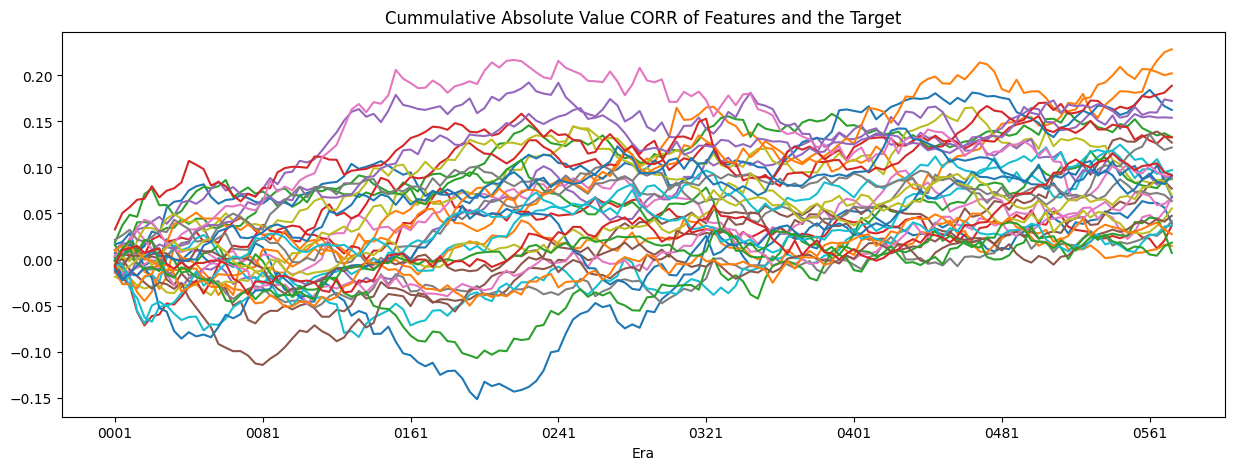

In [ ]:
# plotting the per-era-correlations
per_era_corr.cumsum().plot(title = "Cummulative Absolute Value CORR of Features and the Target" , figsize = (15,5) , legend = False , xlabel = "Era");

In [ ]:
def metric(corr):
  corr_mean = corr.mean()
  corr_std = corr.std(ddof = 0)
  corr_sharpe = corr_mean / corr_std
  max_drawdown = -(corr.cumsum().expanding(min_periods = 1).max() - corr.cumsum()).max()


# delta = absolute difference in mean correlation between the first and second half of analysis period.

  half = len(train["era"].unique())//2
  delta = abs(per_era_corr.iloc[:half].mean() - per_era_corr.iloc[half:].mean())


  df = pd.DataFrame({"mean": corr_mean,
    "std": corr_std.values,
    "sharpe": corr_sharpe.values,
    "max_drawdown": max_drawdown.values,
    "delta":delta.values},index = corr.columns).T

  return df.transpose().sort_values(by = "mean" , ascending = False)

In [ ]:
metric(per_era_corr)

,mean,std,sharpe,max_drawdown,delta
feature_strigose_rugose_interjector,0.001587,0.009814,0.161706,-0.090501,3.219999e-04
feature_pennsylvanian_sibylic_chanoyu,0.001405,0.008630,0.162839,-0.056719,5.891572e-05
feature_honoured_observational_balaamite,0.001311,0.008323,0.157573,-0.070633,4.692690e-04
feature_ichthyotic_roofed_yeshiva,0.001197,0.006447,0.185643,-0.053682,8.730129e-04
feature_exploitative_jetty_oujda,0.001129,0.007438,0.151789,-0.048455,4.028365e-04
feature_styloid_subdermal_cytotoxin,0.001070,0.006940,0.154150,-0.058597,6.228628e-04
feature_plum_anemometrical_guessing,0.000924,0.006496,0.142234,-0.041113,1.081759e-03
feature_aguish_commissioned_tessitura,0.000922,0.008206,0.112337,-0.063597,1.338218e-03
feature_gubernacular_liguloid_frankie,0.000882,0.007530,0.117191,-0.082251,6.352135e-04
feature_demolished_unfrightened_superpower,0.000846,0.007418,0.113985,-0.053589,3.118252e-04


Looking at the summary visualizations below, the most obvious observation is that `mean` and `sharpe` seem strongly correlated. This should not be suprising given that `sharpe` is just `mean` divided by `std`.

A more interesting obvservation is that `mean` does not seem to be strongly correlated with `std`, `max_drawdown`, or `delta`. This tells us very clearly that just because a feature has high `mean` does not mean that it is consistent or low risk.

In the next section we more closely examine `std`, `max_drawdown`, and `delta` to better understand feature risk.

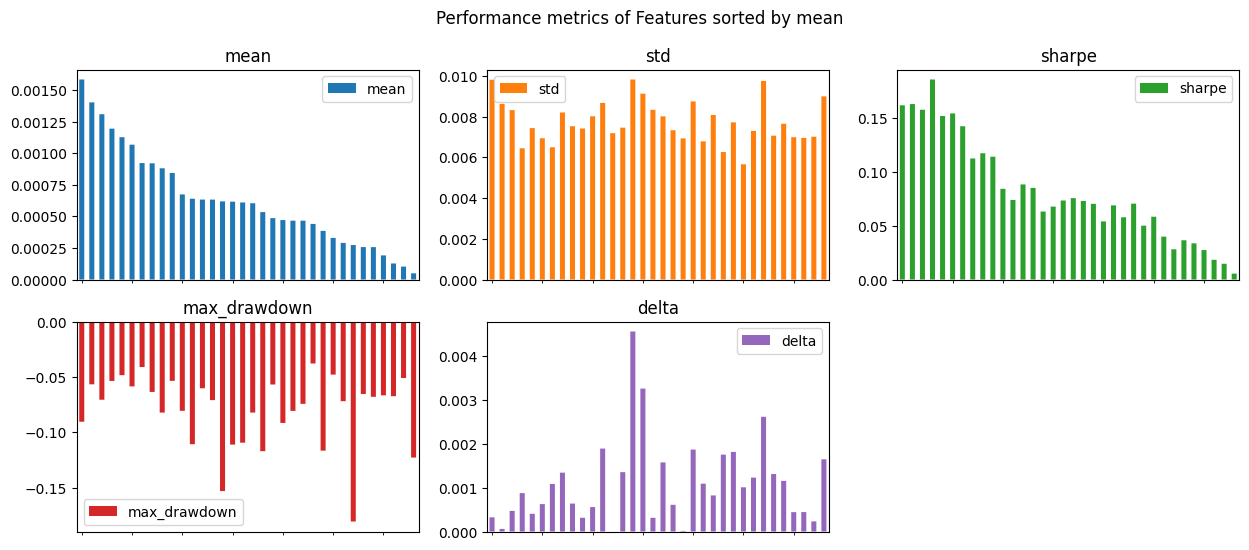

In [ ]:
# examining std , delta, max_drawdown to understand feature risk better
metric(per_era_corr).plot(
    kind = 'bar' ,
    subplots = True,
    figsize = (15,6) ,
    layout = (2,3) ,
    title = "Performance metrics of Features sorted by mean" ,
    xticks = [] ,
    snap = False
);

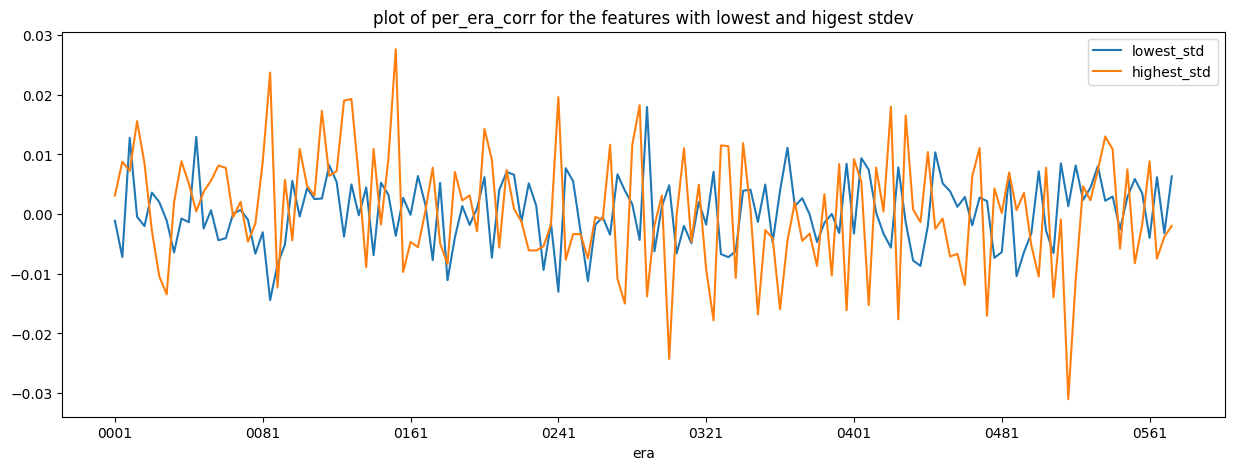

In [ ]:
# comparing feature risk
import matplotlib.pyplot as plt

per_era_corr[[metric(per_era_corr)["std"].idxmin() , metric(per_era_corr)["std"].idxmax()]].plot(
    figsize = (15, 5) ,
    title = "plot of per_era_corr for the features with lowest and higest stdev"
  );
plt.legend(["lowest_std" , "highest_std"]);

# i think orange one is more risky

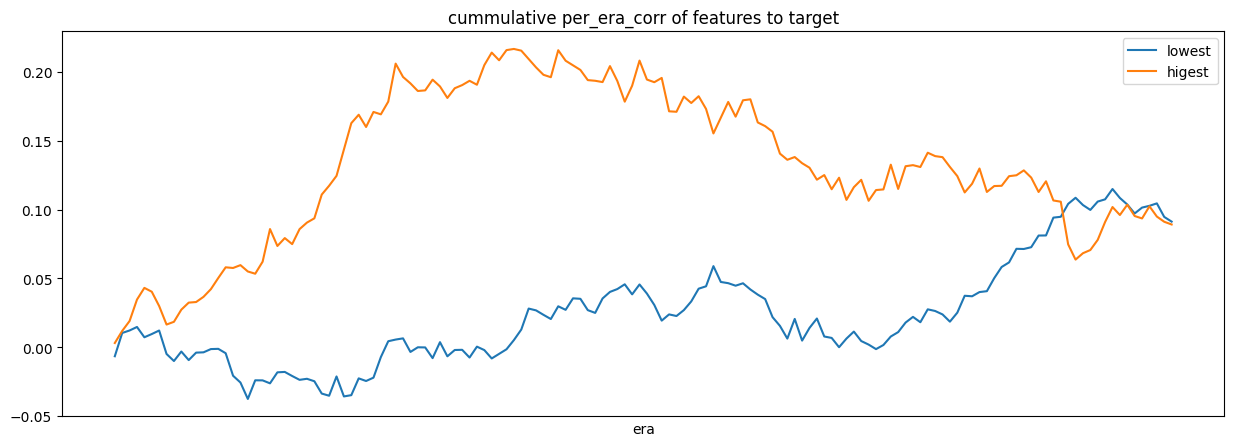

In [ ]:
per_era_corr[[metric(per_era_corr)["delta"].idxmin(),metric(per_era_corr)["delta"].idxmax()]].cumsum().plot(xticks = [], title = "cummulative per_era_corr of features to target", figsize = (15,5));
plt.legend(["lowest" , "higest"]);

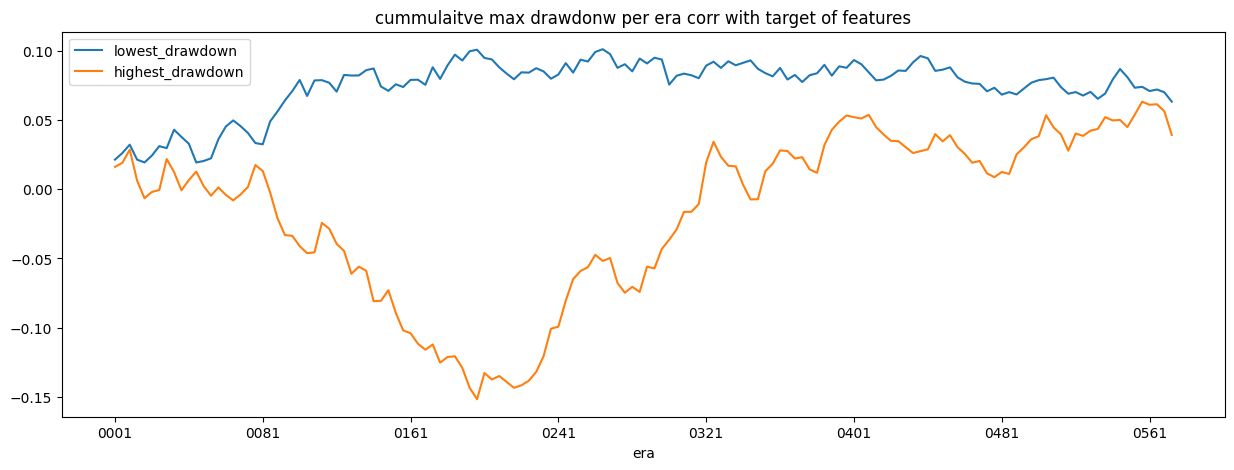

In [ ]:
per_era_corr[[metric(per_era_corr)["max_drawdown"].idxmax() , metric(per_era_corr)["max_drawdown"].idxmin()]].cumsum().plot(title = "cummulaitve max drawdonw per era corr with target of features" , xlabel = "era" , figsize = (15,5));
plt.legend(["lowest_drawdown","highest_drawdown"]);

In [ ]:
# model training
import lightgbm as lgb
model = lgb.LGBMRegressor(n_estimators = 2000 , learning_rate = 0.01 , max_depth = 5 , num_leaves = 2**4-1 , colsample_bytree = 0.1)
model.fit(train[medium_features] , train["target"])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 606176, number of used features: 705
[LightGBM] [Info] Start training from score 0.499979


LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000, num_leaves=15)

## 2. Feature Exposure

`Feature exposure` is a measure of a model's exposure to the risk of individual features, given by the Pearson correlation between a model's predictions and each feature. Let's load up and predict on the validation data for our medium feature set.

In [40]:
napi.download_dataset(f"{DATA_VERSION}/validation_int8.parquet")

validation = pd.read_parquet(f"{DATA_VERSION}/validation_int8.parquet" , columns = ["era" , "data_type", "target"]+ medium_features)

validation = validation[validation["data_type"] == "validation"]
del validation["data_type"]


# downsampling to every 4th era for memory issues
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]

# embargo overlapping era from training datset to avoid data leakage

last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]


validation = validation[~validation["era"].isin(eras_to_embargo)]

# generating predictions against the medium feature set of the validation data
validation["Prediction"] = model.predict(validation[medium_features])

### Visualizing feature exposures

As seen in the chart below, our model seems to be consistently correlated to a few features. If these features suddenly reverse or stop working, then our model predictions will likely exhibit the same risky characteristics we saw above.

In [48]:
# pearson corr. of prediction with each of the serenity features of medium feature set.
validation =validation.groupby("era").apply(
    lambda d: d[med_serenity_feats].corrwith(d["Prediction"])
)

In [49]:
validation

,feature_genuine_kyphotic_trehala,feature_strigose_rugose_interjector,feature_plum_anemometrical_guessing,feature_untidy_withdrawn_bargeman,feature_styloid_subdermal_cytotoxin,feature_gubernacular_liguloid_frankie,feature_nappiest_unportioned_readjustment,feature_reposeful_apatetic_trudeau,feature_sarmatia_foldable_eutectic,feature_iconoclastic_parietal_agonist,...,feature_ichthyotic_roofed_yeshiva,feature_ironfisted_nonvintage_chlorpromazine,feature_castigatory_hundredfold_hearthrug,feature_indusiate_canned_cosh,feature_binding_lanky_rushing,feature_olden_enchained_leek,feature_unenthralled_sportful_schoolhouse,feature_unadaptable_floored_styptic,feature_diarrhoeic_relieved_scutter,feature_waggly_outlandish_carbonisation
era,,,,,,,,,,,,,,,,,,,,,
0579,0.027779,0.082479,0.006386,0.049430,0.003411,0.028568,0.034665,-0.003458,-0.008370,0.001657,...,0.012492,0.073697,0.022658,0.070869,0.040593,-0.005921,0.035449,-0.020943,-0.017496,0.010644
0583,0.015203,0.079928,-0.008178,0.028707,-0.027242,-0.000762,0.039449,-0.007839,0.005779,-0.042384,...,0.002627,0.049005,0.030212,0.053713,0.019706,0.025444,0.037481,-0.020106,-0.021089,-0.012158
0587,0.008292,0.059344,-0.010523,0.026215,0.009179,-0.001202,0.049844,-0.001481,-0.024548,-0.050095,...,0.001060,-0.007864,-0.000784,-0.015760,0.024459,0.025604,0.045790,0.013825,-0.006207,-0.007473
0591,-0.011884,0.013387,-0.018803,0.055059,0.043389,0.011937,0.064351,0.027993,-0.027737,-0.025271,...,0.002609,-0.035887,-0.009528,-0.059885,0.059164,0.032088,0.052655,0.056388,0.020325,0.006630
0595,-0.032405,-0.000698,-0.029611,0.078099,0.073043,0.027273,0.047609,0.059131,-0.028196,-0.046585,...,-0.004424,-0.088735,-0.027974,-0.110728,0.077958,0.051245,0.044447,0.104490,0.054640,0.019586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,0.042179,0.107708,0.048760,0.082533,-0.021298,0.034197,-0.048118,0.003852,0.042850,-0.061987,...,0.023654,-0.039907,-0.007432,-0.039048,0.062019,-0.040764,-0.051211,-0.030393,0.006745,0.033358
1087,0.047191,0.083387,0.049850,0.081964,0.000956,0.003824,-0.055095,0.020800,0.032268,-0.085078,...,0.026342,-0.039626,-0.009074,-0.045401,0.061806,-0.028817,-0.049649,-0.010448,0.012010,0.007550
1091,0.057979,0.068554,0.053830,0.088571,0.036728,0.062269,-0.070520,0.055977,0.032185,-0.040432,...,0.038631,-0.053713,-0.011924,-0.062031,0.077812,-0.011972,-0.066199,0.041052,0.045494,0.064429
